In [32]:
# Decode variable from MEG source or sensor data

# Author: Laura Gwilliams
# Contact: leg5@nyu.edu
# Dependencies: MNE-Python, numpy, sklearn
# Input: Responses of a brain region (X) and their class (y)
# Output: Matrix of classification accuracies

#-#-#

from __future__ import division

import numpy as np
import scipy as sp
from mne import create_info
from mne.decoding import TimeDecoding, GeneralizationAcrossTime
from mne.datasets import sample
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from scipy import stats


def eelbrain_to_MNE_epoch(e, subj, data_type, ROI, epoch, variable, categorical_continuous,
                    tstart, tstop, decim, subset_labels):
    """
    e:                  eelbrain experiment object
    subj:               the subject to load data
    data_type:          "source" or "sensor": source space or sensor space
    ROI:                region to run analysis. must be defined in experiment class
    epoch:              subset of epochs to run analysis. must be defined in e
    variable:           the variable to predict/classify
    categorical_continuous:  whether to classify as binary variables or continuous
    tstart:             when to begin analysis (ms)
    tstop:              when to stop analysis (ms)
    decim:              samples were taken at intervals of how many ms
    subset_labels:      only keep epochs that have these labels

    """

    # set epochs
    e.set(epoch=epoch)

    # set subjects
    e.set(subject=subj)

    # if sensor space load epochs
    if data_type == 'sensor':
        ds = e.load_epochs(subj,ndvar=False)
        data_format = 'epochs'

    # if source space load stc epochs
    if data_type == 'source':
        e.set(parc=ROI)
        # mask is on so that we only load sources in the ROI
        ds = e.load_epochs_stc(subj,mask=True,morph=True)
        data_format = 'srcm'

    # if running a binary test, make sure counts in each class is equal
    if categorical_continuous == 'categorical':
        ds = ds.equalize_counts(variable)
        y = ds[variable].x # pull out numpy array from var

    elif categorical_continuous == 'continuous':
        # determine if it is a Var or Factor
        if 'Factor' in str(ds[variable].__class__):
            extraction_command = 'as_labels()'
        elif 'Var' in str(ds[variable].__class__):
            extraction_command = 'x'
        else:
            raise NotImplementedError('Data type not recognised')

        # get y
        y = eval('ds["%s"].%s' % (str(variable), extraction_command))
        y = map(float,y) # make sure that the values are floats

    # apply subset
    if subset_labels:
        kept_indices = np.array([val in subset_labels for val in ds[variable]])
        ds = ds.sub(kept_indices)

    # just take times of interest
    if data_type == 'sensor':
        # subset the time by finding where tstart and tstop are within the
        # already provided time array in the loaded epochs
        tmin_sensor_index = np.nonzero(ds[data_format].times == tstart)[0][0]
        tmax_sensor_index = np.nonzero(ds[data_format].times == tstop)[0][0]
        ds[data_format]._data = ds[data_format]._data[:,:,tmin_sensor_index:tmax_sensor_index]
        epochs = ds[data_format]
        epochs.times = epochs.times[tmin_sensor_index:tmax_sensor_index] # update time array

    elif data_type == 'source':

        times = ds[data_format].time.times
        epochs = nparray_to_MNE_epoch(ds[data_format].x, times, tstart, tstop)

    evoked = epochs.average()

    # return X, y_true and evoked
    return epochs, y, evoked

def stc_to_MNE_epoch(stc_list, tstart, tstop):

    # if we are coersing source data into an epochs array, things are more
    # complicated, and we need to mess around with the .info dictionary:

    # first make an array of ones to populate w/ real data
    data_times = stc_list[0].times
    data_shape = stc_list[0].shape
    thisSTC = np.ones([data_shape[0], data_shape[1], len(stc_list)])
    # loop through each stc and put data into the ones array
    for ii in xrange(0,len(stc_list)):
        thisSTC[:,:,ii] = stc_list[ii].data

    # reshape the stc data so that it is trial * source * time
    data_shape = thisSTC.shape
    thisSTC = np.reshape(thisSTC,[data_shape[2], data_shape[0], data_shape[1]])

    epochs = nparray_to_MNE_epoch(thisSTC, data_times, tstart, tstop)

    return epochs

def nparray_to_MNE_epoch(data_array, times, tstart, tstop):
    """
    Convert numpy array into MNE Epochs object for decoding.

    data_array:         numpy array of brain data. shape (trial * space * time)
    times:              numpy array of times
    tstart:             desired time start (float)
    tstop:              desired time stop (float)

    """

    # fix the timing
    timing = np.round(map(float,times),decimals=3)
    tmin_sensor_index = np.nonzero(timing == tstart)[0][0]
    tmax_sensor_index = np.nonzero(timing == tstop)[0][0]
    data_array = data_array[:,:,tmin_sensor_index:tmax_sensor_index]

    # make an empty epochs object to populate
    data_path = sample.data_path()
    path_to_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
    dummy_raw = mne.io.Raw( path_to_raw, preload=True )
    dummy_events = mne.find_events(dummy_raw)

    # get clean epochs
    epochs = mne.Epochs(dummy_raw, dummy_events, event_id=1, picks=None,
                        tmin=tstart, tmax=tstop, preload=True)
    epochs._data = data_array
    epochs.events = np.array([[0,0,1]] * data_array.shape[0])
    epochs.picks = None

    ### fix info about channels because now we have sources

    # first, make sure now bad channels are specified
    epochs.info['bads'] = []

    # next, find how many time points we have
    source_range = range(0,epochs._data.shape[1])

    # make a info['chs'] dictionary to fool the MNE-Python consistency checker
    first_dict_ch = epochs.info['chs'][0].copy() # this is the original entry for the first channel
    chs_dict_list = []
    for ch_n in source_range: # loop through each channel and populate the list of dicts accordingly
        first_dict_ch['ch_name'] = str(ch_n) # change the channel name to be the source number
        chs_dict_list.append(first_dict_ch.copy()) # add this updated dict entry to the list of dicts

    # now populate the info of the epochs object
    epochs.info['chs'] = chs_dict_list
    epochs.info['ch_names'] = map(str,source_range)
    epochs.info['nchan'] = int( epochs._data.shape[1] )

    # fix the timing bcz of decimation
    decim = float(np.round(times[1] - times[0],decimals=3))
    ms_start = float( tstart )
    ms_stop = float( tstop )
    new_range = [ np.round(x,decimals=3) for x in np.arange(ms_start, ms_stop, decim) ] #Last number is the decimation factor
    epochs.times = np.array( new_range )

    return epochs

def scorer_spearman(y_true, y_pred):
    from scipy.stats import spearmanr
    if y_pred.ndim > 1:
        y_pred = y_pred[:, 0]
    sel = np.where(~np.isnan(y_true + y_pred))[0]
    rho, p = spearmanr(y_true[sel], y_pred[sel])
    return rho

def decode_MEG(X, y_true, categorical_continuous, scorer=mean_squared_error,
                subset_labels=None, decoder=GeneralizationAcrossTime):

    """
    Runs GAT classifier on source or space data, on binary or continuous variables.

    X:                  brain data
    y_true:             values to decode
    categorical_continuous:  whether to classify as binary variables or continuous
    scorer:             type of scorer to use if working with continuous variables.
                        'mean_squared_error' (default), 'rank_scorer'...
    """

    # regression parameters
    random_state = 42

    # this is a recommended value, you can actually find the optimum value in a grid search (cf. sklearn)
    reg = Ridge(alpha=1e-3)
    #logistic = linear_model.LogisticRegression()

    # create classification object
    if categorical_continuous == 'continuous':
        clf = Pipeline([('scaler', StandardScaler()), ('ridge', reg)])
        cv = KFold(n=len(y), n_folds=5, random_state=random_state)
        ld = decoder(clf=clf, scorer=scorer, n_jobs=-1, cv=cv)
    else:
        ld = decoder(predict_mode='cross-validation', n_jobs=-1, scorer=scorer)

    # fit the classifier, predict y, and get scores.
    ld.fit(X, y=y)
    ld.predict(X)
    ld.score(y=y)

    return ld


Opening raw data file /Users/lauragwilliams/Documents/programming/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
Current compensation grade : 0
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Opening raw data file /Users/lauragwilliams/Documents/programming/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
Current compensation grade : 0
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
319 events found
Events id: [ 1  2  3  4  

[Parallel(n_jobs=4)]: Done   5 out of   4 | elapsed:    6.8s remaining:   -1.4s
[Parallel(n_jobs=4)]: Done   5 out of   4 | elapsed:    7.1s remaining:   -1.4s
[Parallel(n_jobs=4)]: Done   5 out of   4 | elapsed:    7.3s remaining:   -1.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Done   5 out of   4 | elapsed:    0.2s remaining:   -0.0s
[Parallel(n_jobs=4)]: Done   5 out of   4 | elapsed:    0.2s remaining:   -0.0s
[Parallel(n_jobs=4)]: Done   5 out of   4 | elapsed:    0.2s remaining:   -0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


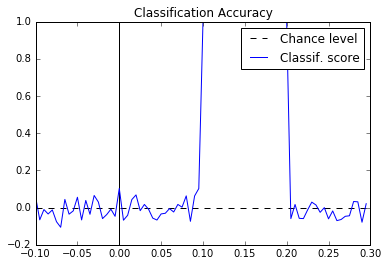

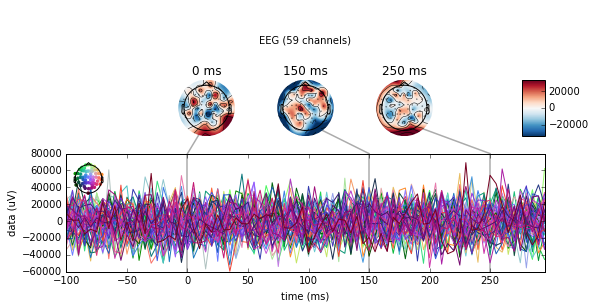

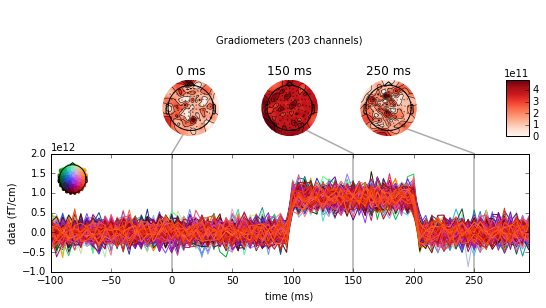

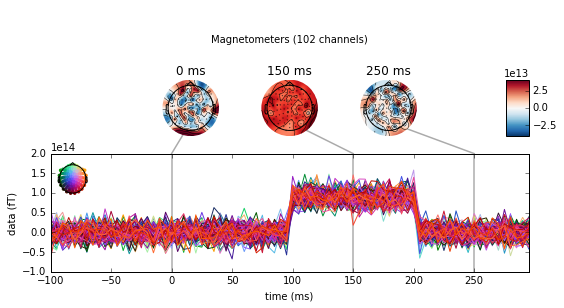

In [60]:
# Example usage:

# make an empty epochs object to populate
data_path = sample.data_path()
path_to_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
dummy_raw = mne.io.Raw( path_to_raw, preload=True )

# set up dimenions of simulated data
n_trials = 1000
n_sensors = dummy_raw.info['nchan']
times = np.round(np.arange(-0.1,0.5,0.005),decimals=3)
n_timepoints = len(times)
snr = 3

# create a y variable to predict
y = np.random.randint(low=-1000,high=1000,size=n_trials)/1000

# simulate MEG data
data_array = np.random.randint(low=-1000,high=1000,size=(n_trials, n_sensors, n_timepoints))/1000

# loop through trials from 100-200 ms and inject stimulus response
idx_tmin = np.nonzero(0.1 == times)[0][0]
idx_tmax = np.nonzero(0.2 == times)[0][0]

# find location of MEG sensors and add signal to first 100
meg_sensor_boolean = ['MEG' in ch for ch in epochs.info['ch_names']]
sensor_indx = np.nonzero(meg_sensor_boolean)[0]

for ms_response in np.arange(idx_tmin, idx_tmax+1):
    
    # and do this for just half of the sensors:
    for sensor in sensor_indx:
        
        # add true responses over the noise
        data_array[:,sensor,ms_response] = data_array[:,sensor,ms_response] + y*snr

# transform data array into MNE Epochs object
tstart = -0.1 # time within epoch to run analysis (min)
tstop = 0.3 # time within epoch to run analysis (max)
epochs = nparray_to_MNE_epoch(data_array, times, tstart, tstop)
epochs.info = dummy_raw.info
evoked = epochs.average()

# decode y from epochs
ld = decode_MEG(epochs, y, 'continuous', decoder=TimeDecoding, scorer=scorer_spearman)

# plot result
%matplotlib inline
ld.plot(chance=0, title='Classification Accuracy', xlabel='Time (ms)', ylabel='Spearmans R')

# plot evoked brain response
evoked.plot_joint(times=[0,0.15,0.25])
